# Import Libraries

In [1]:
#import the useful libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import missingno as msno
from sklearn.model_selection import train_test_split
import scipy.stats as stats
import pymssql
import pickle
warnings.filterwarnings('ignore')
%matplotlib inline
import mysql.connector
from mysql.connector import Error

# Database connection to MSSQL Server

In [2]:
try:
    mysqldb = pymssql.connect(server="172.20.10.3", user="sa", password="your_password", database="KAGGLE")
    mycursor = mysqldb.cursor()
    mycursor.execute ("SELECT @@VERSION")
    row = mycursor.fetchone()
    print(f"\n\nSERVER VERSION:\n\n{row[0]}")
    #mycursor.close()
    #mysqldb.close()
except Exception:
    print("\nERROR: Unable to connect to the server.")
    exit(-1)



SERVER VERSION:

Microsoft Azure SQL Edge Developer (RTM) - 15.0.2000.1562 (ARM64) 
	Jan 14 2022 15:23:35 
	Copyright (C) 2019 Microsoft Corporation
	Linux (Ubuntu 18.04.6 LTS aarch64) <ARM64>


# Call query table from MSSQL Server

In [3]:
sql_query = """SELECT*FROM RETAIL_SALES;""".format(input)
df = pd.read_sql_query(sql_query , mysqldb)

df

,data,quantity,SKU,price
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29
...,...,...,...,...
932,2016-07-27,98,3179,2.39
933,2016-07-28,108,3071,2.39
934,2016-07-29,128,4095,2.39
935,2016-07-30,270,3825,2.39


In [4]:
df.head(5)

,data,quantity,SKU,price
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29


In [5]:
print('The shape of Retail Sales Forecast dataset is:', df.shape)

The shape of Retail Sales Forecast dataset is: (937, 4)


In [6]:
# Descriptive statistics for each column
df.describe()

,quantity,SKU,price
count,937.000000,937.000000,937.000000
mean,90.533618,1608.258271,1.592572
std,80.682089,1356.691877,0.529502
min,0.000000,0.000000,0.000000
25%,33.000000,794.000000,1.290000
50%,76.000000,1348.000000,1.390000
75%,127.000000,1964.000000,1.890000
max,542.000000,7228.000000,2.980000


# Data Cleaning

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   data      937 non-null    object 
 1   quantity  937 non-null    int64  
 2   SKU       937 non-null    int64  
 3   price     937 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 29.4+ KB


In [8]:
# Checking the missing values
df.isnull().sum()

data        0
quantity    0
SKU         0
price       0
dtype: int64

In [9]:
df['data'] = pd.to_datetime(df['data'])
df = df.set_index('data')
df=df.dropna()
df

,quantity,SKU,price
data,,,
2014-01-01,0,4972,1.29
2014-01-02,70,4902,1.29
2014-01-03,59,4843,1.29
2014-01-04,93,4750,1.29
2014-01-05,96,4654,1.29
...,...,...,...
2016-07-27,98,3179,2.39
2016-07-28,108,3071,2.39
2016-07-29,128,4095,2.39


# Handling Outlier

Text(0.5, 0, 'quantity')

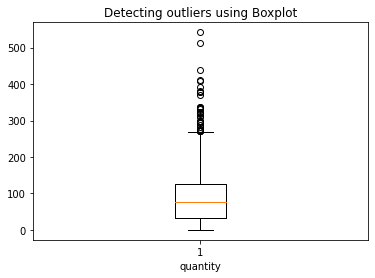

In [10]:
# Detecting outliers from FFB_Yield
plt.boxplot(x=df['quantity'])
plt.title("Detecting outliers using Boxplot")
plt.xlabel('quantity')

Text(0.5, 0, 'price')

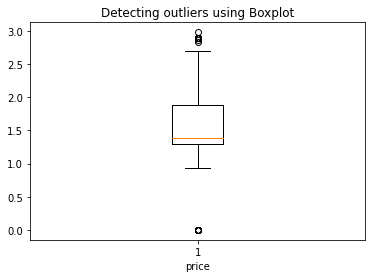

In [11]:
# Detecting outliers from FFB_Yield
plt.boxplot(x=df['price'])
plt.title("Detecting outliers using Boxplot")
plt.xlabel('price')

# Removing Outliers by using Interquartile range (IQR) method

In [12]:
Q1=df.quantile(0.25)
Q3=df.quantile(0.75)
IQR=Q3-Q1
df2 =df[~((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))]

In [13]:
#find how many rows are left in the dataframe 
df2.shape

(937, 3)

<AxesSubplot:>

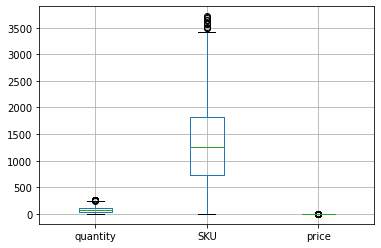

In [14]:
df2.boxplot()

# Correlation 

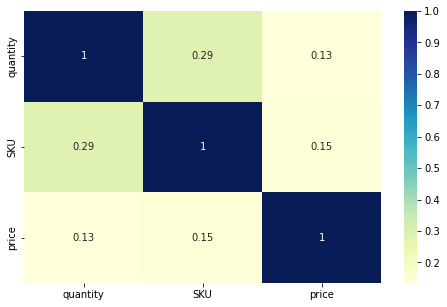

In [15]:
# Lets explore the correlations in our data set 
import seaborn as sns
plt.figure(figsize=(8,5))
sns.heatmap(df2.corr(), cmap="YlGnBu", annot=True)
plt.savefig('retail_sales_forecast.png')

In [16]:
df2=df2.dropna()
df2.shape
df2

,quantity,SKU,price
data,,,
2014-01-25,198.0,3595.0,1.09
2014-01-26,168.0,3427.0,1.09
2014-01-27,125.0,3302.0,1.09
2014-01-28,86.0,3216.0,1.09
2014-01-29,222.0,2994.0,0.99
...,...,...,...
2016-07-25,62.0,1358.0,2.39
2016-07-26,97.0,2893.0,2.39
2016-07-27,98.0,3179.0,2.39


# Divide the dataset into test and train set

In [17]:
X = df2.drop(['quantity','SKU'], axis = 1)
X.head 

<bound method NDFrame.head of             price
data             
2014-01-25   1.09
2014-01-26   1.09
2014-01-27   1.09
2014-01-28   1.09
2014-01-29   0.99
...           ...
2016-07-25   2.39
2016-07-26   2.39
2016-07-27   2.39
2016-07-28   2.39
2016-07-31   2.39

[790 rows x 1 columns]>

In [18]:
Y = df2.drop(['price', 'SKU'], axis = 1)
Y.head

<bound method NDFrame.head of             quantity
data                
2014-01-25     198.0
2014-01-26     168.0
2014-01-27     125.0
2014-01-28      86.0
2014-01-29     222.0
...              ...
2016-07-25      62.0
2016-07-26      97.0
2016-07-27      98.0
2016-07-28     108.0
2016-07-31     183.0

[790 rows x 1 columns]>

# Split into train test sets

In [19]:
y_train = Y.iloc[:785, 0:1]
X_train = X.iloc[:785,0:1]

y_test = Y.iloc[785:, 0:1]
X_test = X.iloc[785:,0:1]

# Scaling the data

In [20]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [21]:
sc.fit_transform(X_train)
sc.transform(X_test)

array([[1.80057869],
       [1.80057869],
       [1.80057869],
       [1.80057869],
       [1.80057869]])

# XGBoost Model

In [22]:
import xgboost as xgb

In [23]:
# Fine tune parameter here:
model = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.25,
                max_depth = 10, alpha = 10, n_estimators = 1000, scale_pos_weight=5, random_state=100, reg_lambda=0.001)

In [24]:
# fit model
regressorXGB = model.fit(X_train, y_train)

[23:02:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [25]:
with open('regressorXGB.pkl','wb') as model:
   pickle.dump(regressorXGB, model)

In [26]:
# Predicting the target values of the test set
y_pred = regressorXGB.predict(X_test)

In [27]:
y_pred

array([133.52922, 133.52922, 133.52922, 133.52922, 133.52922],
      dtype=float32)

In [28]:
y_pred=y_pred.reshape(5,1)

In [29]:
pred_y_df = pd.DataFrame(np.concatenate((y_pred,y_test),1), columns=['Prediction', 'Actual'])
pred_y_df.head(5)

,Prediction,Actual
0,133.529221,62.0
1,133.529221,97.0
2,133.529221,98.0
3,133.529221,108.0
4,133.529221,183.0


In [30]:
pred_y_df

,Prediction,Actual
0,133.529221,62.0
1,133.529221,97.0
2,133.529221,98.0
3,133.529221,108.0
4,133.529221,183.0


<AxesSubplot:title={'center':'Actual Test Set Vs. Prediction XGBoost'}>

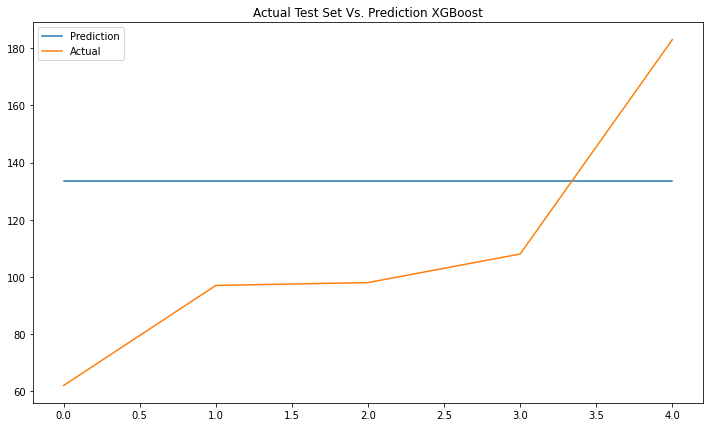

In [31]:
pred_y_df.plot(figsize=(12,7), title="Actual Test Set Vs. Prediction XGBoost", legend=True)

In [33]:
from sklearn.linear_model import LinearRegression
regressor1 = LinearRegression()
regressor1.fit(X_train, y_train)
with open('regressor1.pkl','wb') as model1:
   pickle.dump(regressor1, model1)


In [34]:

pred = regressor1.predict(X_test)
prediction= np.exp(pred)
actual=np.exp(y_test)

comparison=pd.DataFrame(np.concatenate((actual,prediction), 1))
comparison.rename({ 0:'Actual Demand Qty',1:'Predictions Demand Qty',}, axis=1, inplace=True)

In [35]:
comparison

,Actual Demand Qty,Predictions Demand Qty
0,8.438357e+26,1.028963e+41
1,1.338335e+42,1.028963e+41
2,3.637971e+42,1.028963e+41
3,8.013164e+46,1.028963e+41
4,2.991508e+79,1.028963e+41


<AxesSubplot:title={'center':'Actual Test Set Vs. Prediction MLR'}>

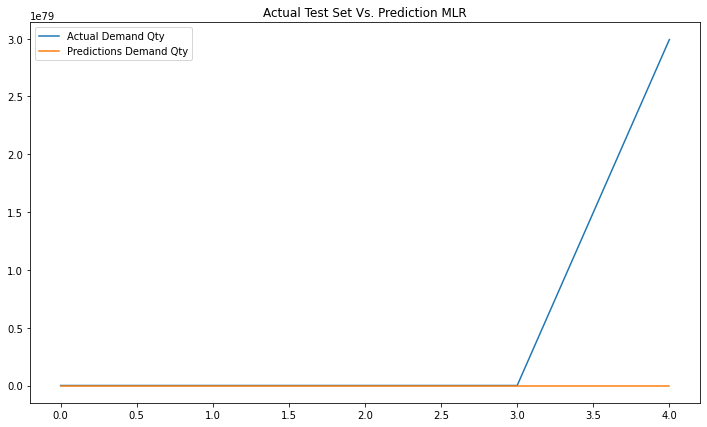

In [36]:
comparison.plot(figsize=(12,7), title="Actual Test Set Vs. Prediction MLR", legend=True)